> **Problem overview**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# import skewness from scipy
from scipy.stats import skew

# import model function from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import model selection from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# import model evaluation regression metrics from sklearn
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
train_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
# visualize tail of the testing data
test_df.tail(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [5]:
# convert training dataframe sale price to log sale price
train_df['SalePrice'] = train_df['SalePrice'].apply(lambda x: np.log1p(x))

In [6]:
# combine training and testing dataframe
train_df['DataType'], test_df['DataType'] = 'training', 'testing'
test_df.insert(test_df.shape[1] - 1, 'SalePrice', 0)
data_df = pd.concat([train_df, test_df])
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699,training
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016,training
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171,training


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [7]:
# describe training and testing data
data_df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
count,2919.000000,2919.000000,2915,2433.000000,2919.000000,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919,2919,2918,2918,2895,2896.000000,2919,2919,2919,2838,2837,2837,2840,2918.000000,2839,2918.000000,2918.000000,2918.000000,2919,...,2918,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918,2919.000000,2917,2919.000000,1499,2762,2760.000000,2760,2918.000000,2918.000000,2760,2760,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,10,571,105,2919.000000,2919.000000,2919.000000,2918,2919,2919.000000,2919
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN,2
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Ex,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,training
freq,NaN,NaN,2265,NaN,NaN,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,NaN,NaN,NaN,NaN,2310,2876,1025,1014,1742,NaN,1798,2538,1308,1283,2606,1904,851,NaN,2493,NaN,NaN,NaN,2874,...,2671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492,NaN,2717,NaN,744,1723,NaN,1230,NaN,NaN,2604,2654,2641,NaN,NaN,NaN,NaN,NaN,NaN,4,329,95,NaN,NaN,NaN,2525,2402,NaN,1460
mean,1460.000000,57.137718,NaN,69.305795,10168.114080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.089072,5.564577,1971.312778,1984.264474,NaN,NaN,NaN,NaN,NaN,102.201312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,441.423235,NaN,49.582248,560.772104,1051.777587,NaN,...,NaN,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,NaN,6.451524,NaN,0.597122,NaN,NaN,1978.113406,NaN,1.766621,472.874572,NaN,NaN,NaN,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,NaN,NaN,NaN,50.825968,6.213087,2007.792737,NaN,NaN,6.014088,NaN
std,842.787043,42.517628,NaN,23.344905,7886.996359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.409947,1.113131,30.291442,20.894344,NaN,NaN,NaN,NaN,NaN,179.334253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.610826,NaN,169.205611,439.543659,440.766258,NaN,...,NaN,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,NaN,1.569379,NaN,0.646129,NaN,NaN,25.574285,NaN,0.761624,215.394815,NaN,NaN,NaN,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,NaN,NaN,NaN,567.402211,2.714762,1.314964,NaN,NaN,6.019689,NaN
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1895.0000

In [8]:
# feature extraction: simple fillna for all columns
for col in data_df.select_dtypes(include=['number']).columns.tolist():
    skewness = skew(data_df[col].dropna())
    if skewness > 0.75: data_df[col] = np.log1p(data_df[col])
    data_df[col] = data_df[col].fillna(data_df[col].mean())
for col in data_df.select_dtypes(include=['object']).columns.tolist():
    data_df[col] = data_df[col].fillna(data_df[col].value_counts().idxmax())

In [9]:
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
0,1,4.110874,RL,4.189655,9.042040,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,...,SBrkr,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,Gd,2.197225,Typ,0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,4.127134,0.0,0.0,0.0,0.0,Ex,MnPrv,Shed,0.0,2,2008,WD,Normal,12.247699,training
1,2,3.044522,RL,4.394449,9.169623,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,...,SBrkr,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,TA,1.945910,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,5.700444,0.000000,0.0,0.0,0.0,0.0,Ex,MnPrv,Shed,0.0,5,2007,WD,Normal,12.109016,training
2,3,4.110874,RL,4.234107,9.328212,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,...,SBrkr,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,Gd,1.945910,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,3.761200,0.0,0.0,0.0,0.0,Ex,MnPrv,Shed,0.0,9,2008,WD,Normal,12.317171,training


After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [10]:
# verify dtypes object
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null float64
MSZoning         2919 non-null object
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919

In [11]:
# convert dtypes object to category
col_obj = data_df.select_dtypes(['object']).columns
data_df[col_obj] = data_df[col_obj].astype('category')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null float64
MSZoning         2919 non-null category
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null category
Alley            2919 non-null category
LotShape         2919 non-null category
LandContour      2919 non-null category
Utilities        2919 non-null category
LotConfig        2919 non-null category
LandSlope        2919 non-null category
Neighborhood     2919 non-null category
Condition1       2919 non-null category
Condition2       2919 non-null category
BldgType         2919 non-null category
HouseStyle       2919 non-null category
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null category
RoofMatl         2919 non-null 

In [12]:
# convert dtypes category to category codes
col_cat = data_df.select_dtypes(['category']).columns
data_df[col_cat] = data_df[col_cat].apply(lambda x: x.cat.codes)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null float64
MSZoning         2919 non-null int8
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null int8
Alley            2919 non-null int8
LotShape         2919 non-null int8
LandContour      2919 non-null int8
Utilities        2919 non-null int8
LotConfig        2919 non-null int8
LandSlope        2919 non-null int8
Neighborhood     2919 non-null int8
Condition1       2919 non-null int8
Condition2       2919 non-null int8
BldgType         2919 non-null int8
HouseStyle       2919 non-null int8
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null int8
RoofMatl         2919 non-null int8
Exterior1st      2919 non-null int8
Exterior2nd    

In [13]:
data_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
0,1,4.110874,3,4.189655,9.042040,1,0,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,5.283204,2,4,2,2,3,3,2,6.561031,5,0.0,5.017280,6.753438,1,...,4,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,2,2.197225,6,0,2,1,2003.0,1,2.0,548.0,4,4,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0,2,2,0.0,2,2008,8,4,12.247699,1
1,2,3.044522,3,4.394449,9.169623,1,0,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.000000,3,4,1,2,3,1,0,6.886532,5,0.0,5.652489,7.141245,1,...,4,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,3,1.945910,6,1,4,1,1976.0,1,2.0,460.0,4,4,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0,2,2,0.0,5,2007,8,4,12.109016,1
2,3,4.110874,3,4.234107,9.328212,1,0,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,5.093750,2,4,2,2,3,2,2,6.188264,5,0.0,6.075346,6.825460,1,...,4,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,2,1.945910,6,1,4,1,2001.0,1,2.0,608.0,4,4,2,0.000000,3.761200,0.0,0.0,0.0,0.0,0,2,2,0.0,9,2008,8,4,12.317171,1


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

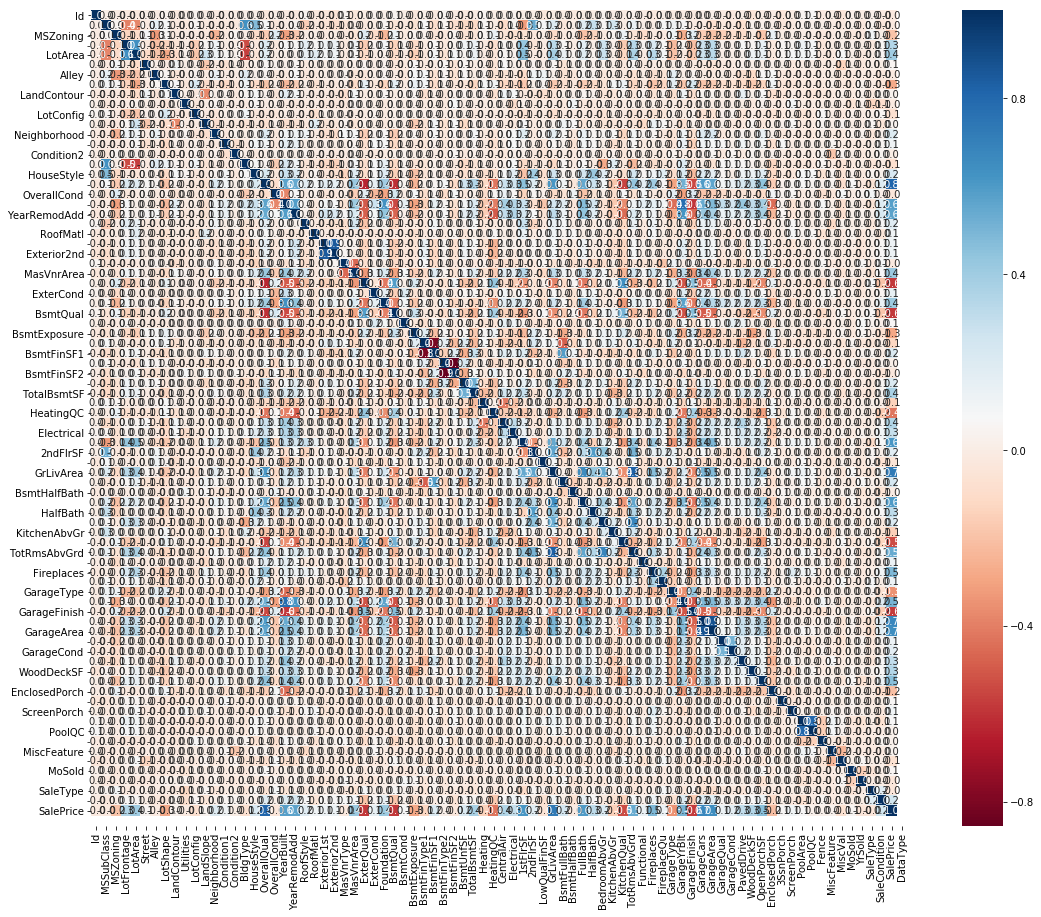

In [14]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = data_df[data_df['DataType'] == 1].corr()
fig, ax = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True);

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

In [15]:
# plot pairwise relationships in a dataset
#pairplot = sns.pairplot(data_df[data_df['DataType'] == 1], diag_kind='kde', diag_kws=dict(shade=True), hue='SalePrice')

The pivot table and other visulized plots are also another useful methods to observe the impact between features.

In [16]:
# pivot table
pivottable = pd.pivot_table(data_df[data_df['DataType'] == 1], aggfunc=np.mean,
                            columns=['MSSubClass'], index=['YearBuilt'], values='SalePrice')
pivottable.style.background_gradient(cmap='Blues')

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


MSSubClass,3.044522437723423,3.4339872044851463,3.713572066704308,3.828641396489095,3.9318256327243257,4.110873864173311,4.2626798770413155,4.330733340286331,4.394449154672439,4.454347296253507,4.51085950651685,4.795790545596741,5.081404364984463,5.198497031265826,5.25227342804663
YearBuilt,,,,,,,,,,,,,,,
1872,nan,nan,nan,nan,nan,nan,11.7118,nan,nan,nan,nan,nan,nan,nan,nan
1875,nan,nan,nan,nan,11.4511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1880,nan,nan,nan,nan,nan,nan,11.9645,12.5947,nan,nan,nan,nan,nan,nan,nan
1882,nan,nan,nan,nan,nan,nan,12.0317,nan,nan,nan,nan,nan,nan,nan,nan
1885,nan,11.5129,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,11.7159
1890,nan,nan,nan,nan,11.7353,nan,11.9798,nan,nan,nan,nan,nan,nan,nan,nan
1892,nan,nan,nan,nan,nan,nan,11.5853,13.0711,nan,nan,nan,nan,nan,nan,nan
1893,nan,nan,nan,nan,nan,nan,nan,12.6916,nan,nan,nan,nan,nan,nan,nan
1898,nan,nan,nan,nan,nan,nan,nan,11.5712,nan,nan,nan,nan,nan,nan,nan


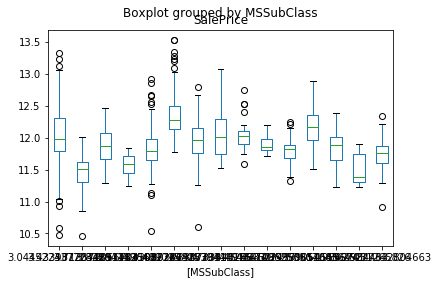

In [17]:
# box plot
boxplot = pd.concat([data_df[data_df['DataType'] == 1]['SalePrice'], data_df[data_df['DataType'] == 1]['MSSubClass']], axis=1).boxplot(by='MSSubClass', grid=False)

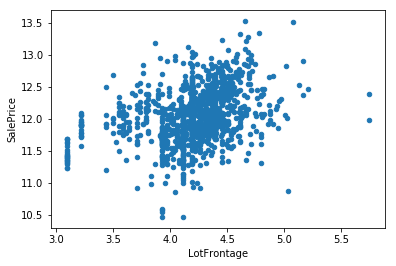

In [18]:
# scatter plot
scatterplot = pd.concat([data_df[data_df['DataType'] == 1]['SalePrice'], data_df[data_df['DataType'] == 1]['LotFrontage']], axis=1).plot.scatter(x='LotFrontage', y='SalePrice')

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [19]:
# select all features to evaluate the feature importances
x = data_df[data_df['DataType'] == 1].drop(['Id', 'SalePrice'], axis=1)
y = data_df[data_df['DataType'] == 1]['SalePrice']

In [20]:
x.head(n=3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,DataType
0,4.110874,3,4.189655,9.042040,1,0,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,5.283204,2,4,2,2,3,3,2,6.561031,5,0.0,5.017280,6.753438,1,0,1,4,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,2,2.197225,6,0,2,1,2003.0,1,2.0,548.0,4,4,2,0.000000,4.127134,0.0,0.0,0.0,0.0,0,2,2,0.0,2,2008,8,4,1
1,3.044522,3,4.394449,9.169623,1,0,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.000000,3,4,1,2,3,1,0,6.886532,5,0.0,5.652489,7.141245,1,0,1,4,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,3,1.945910,6,1,4,1,1976.0,1,2.0,460.0,4,4,2,5.700444,0.000000,0.0,0.0,0.0,0.0,0,2,2,0.0,5,2007,8,4,1
2,4.110874,3,4.234107,9.328212,1,0,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,5.093750,2,4,2,2,3,2,2,6.188264,5,0.0,6.075346,6.825460,1,0,1,4,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,2,1.945910,6,1,4,1,2001.0,1,2.0,608.0,4,4,2,0.000000,3.761200,0.0,0.0,0.0,0.0,0,2,2,0.0,9,2008,8,4,1


In [21]:
# set up random forest regressor to find the feature importances
forestreg = RandomForestRegressor(max_depth=99, n_estimators=2000, random_state=0).fit(x, y)
feat = pd.DataFrame(data=forestreg.feature_importances_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

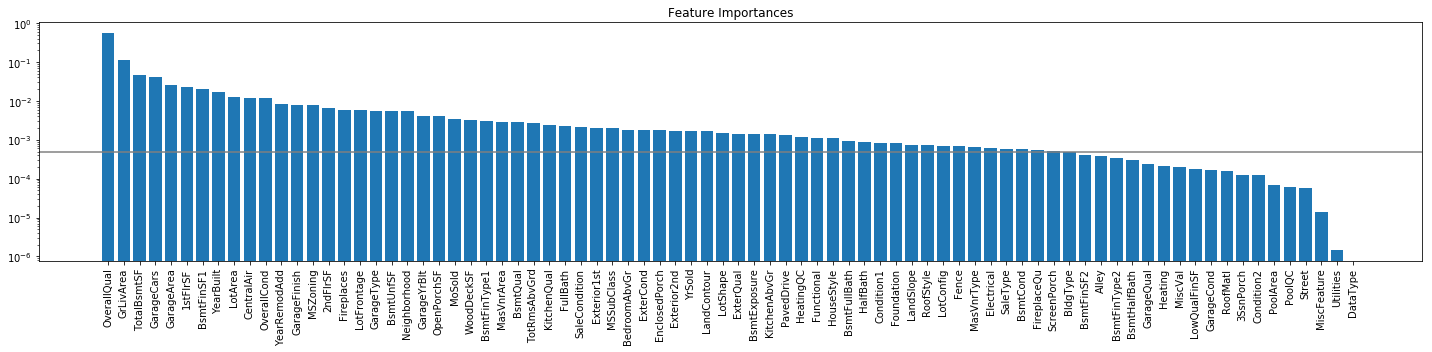

In [22]:
# plot the feature importances
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Feature Importances')
plt.bar(feat.index, feat['FeatureImportances'])
plt.axhline(0.0005, color="grey")
ax.set_xticklabels(feat.index, rotation='vertical')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [23]:
# list all features
data_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [24]:
# list feature importances
feat[feat['FeatureImportances'] > 0.0005].index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea',
       '1stFlrSF', 'BsmtFinSF1', 'YearBuilt', 'LotArea', 'CentralAir',
       'OverallCond', 'YearRemodAdd', 'GarageFinish', 'MSZoning', '2ndFlrSF',
       'Fireplaces', 'LotFrontage', 'GarageType', 'BsmtUnfSF', 'Neighborhood',
       'GarageYrBlt', 'OpenPorchSF', 'MoSold', 'WoodDeckSF', 'BsmtFinType1',
       'MasVnrArea', 'BsmtQual', 'TotRmsAbvGrd', 'KitchenQual', 'FullBath',
       'SaleCondition', 'Exterior1st', 'MSSubClass', 'BedroomAbvGr',
       'ExterCond', 'EnclosedPorch', 'Exterior2nd', 'YrSold', 'LandContour',
       'LotShape', 'ExterQual', 'BsmtExposure', 'KitchenAbvGr', 'PavedDrive',
       'HeatingQC', 'Functional', 'HouseStyle', 'BsmtFullBath', 'HalfBath',
       'Condition1', 'Foundation', 'LandSlope', 'RoofStyle', 'LotConfig',
       'Fence', 'MasVnrType', 'Electrical', 'SaleType', 'BsmtCond',
       'FireplaceQu', 'ScreenPorch'],
      dtype='object')

In [25]:
# select the important features
x = data_df[data_df['DataType'] == 1][feat[feat['FeatureImportances'] > 0.0005].index]
y = data_df[data_df['DataType'] == 1]['SalePrice']

In [26]:
x.head(n=3)

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,BsmtFinSF1,YearBuilt,LotArea,CentralAir,OverallCond,YearRemodAdd,GarageFinish,MSZoning,2ndFlrSF,Fireplaces,LotFrontage,GarageType,BsmtUnfSF,Neighborhood,GarageYrBlt,OpenPorchSF,MoSold,WoodDeckSF,BsmtFinType1,MasVnrArea,BsmtQual,TotRmsAbvGrd,KitchenQual,FullBath,SaleCondition,Exterior1st,MSSubClass,BedroomAbvGr,ExterCond,EnclosedPorch,Exterior2nd,YrSold,LandContour,LotShape,ExterQual,BsmtExposure,KitchenAbvGr,PavedDrive,HeatingQC,Functional,HouseStyle,BsmtFullBath,HalfBath,Condition1,Foundation,LandSlope,RoofStyle,LotConfig,Fence,MasVnrType,Electrical,SaleType,BsmtCond,FireplaceQu,ScreenPorch
0,7,7.444833,6.753438,2.0,548.0,6.753438,6.561031,2003,9.042040,1,5,2003,1,3,6.751101,0,4.189655,1,5.017280,5,2003.0,4.127134,2,0.000000,2,5.283204,2,2.197225,2,2,4,12,4.110874,3,4,0.0,13,2008,3,3,2,3,0.693147,2,0,6,5,1.0,1,2,2,0,1,4,2,1,4,8,3,2,0.0
1,6,7.141245,7.141245,2.0,460.0,7.141245,6.886532,1976,9.169623,1,8,1976,1,3,0.000000,1,4.394449,1,5.652489,24,1976.0,0.000000,5,5.700444,0,0.000000,2,1.945910,3,2,4,8,3.044522,3,4,0.0,8,2007,3,3,3,1,0.693147,2,0,6,2,0.0,0,1,1,0,1,2,2,2,4,8,3,4,0.0
2,7,7.488294,6.825460,2.0,608.0,6.825460,6.188264,2001,9.328212,1,5,2002,1,3,6.765039,1,4.234107,1,6.075346,5,2001.0,3.761200,9,0.000000,2,5.093750,2,1.945910,2,2,4,12,4.110874,3,4,0.0,13,2008,3,0,2,2,0.693147,2,0,6,5,1.0,1,2,2,0,1,4,2,1,4,8,3,4,0.0


In [27]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=0, test_size=0.25)

In [ ]:
# model prediction
linreg = LinearRegression().fit(x_train, y_train)
linreg_ypredict = linreg.predict(x_validate)
linreg_mse = mean_squared_error(y_validate, linreg_ypredict) ** 0.5
linreg_cvscores = np.sqrt(np.abs(cross_val_score(linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(linreg_mse, linreg_cvscores.mean(), 2 * linreg_cvscores.std()))

lassoreg = Lasso(alpha=10).fit(x_train, y_train)
lassoreg_ypredict = lassoreg.predict(x_validate)
lassoreg_mse = mean_squared_error(y_validate, lassoreg_ypredict) ** 0.5
lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(lassoreg_mse, lassoreg_cvscores.mean(), 2 * lassoreg_cvscores.std()))

ridgereg = Ridge(alpha=10).fit(x_train, y_train)
ridgereg_ypredict = ridgereg.predict(x_validate)
ridgereg_mse = mean_squared_error(y_validate, ridgereg_ypredict) ** 0.5
ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(ridgereg_mse, ridgereg_cvscores.mean(), 2 * ridgereg_cvscores.std()))

treereg = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, splitter='best').fit(x_train, y_train)
treereg_ypredict = treereg.predict(x_validate)
treereg_mse = mean_squared_error(y_validate, treereg_ypredict) ** 0.5
treereg_cvscores = np.sqrt(np.abs(cross_val_score(treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(treereg_mse, treereg_cvscores.mean(), 2 * treereg_cvscores.std()))

forestreg = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=250, random_state=0).fit(x_train, y_train)
forestreg_ypredict = forestreg.predict(x_validate)
forestreg_mse = mean_squared_error(y_validate, forestreg_ypredict) ** 0.5
forestreg_cvscores = np.sqrt(np.abs(cross_val_score(forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(forestreg_mse, forestreg_cvscores.mean(), 2 * forestreg_cvscores.std()))

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [ ]:
# model selection
model = ridgereg

# prepare testing data and compute the observed value
x_test = data_df[data_df['DataType'] == 0][feat[feat['FeatureImportances'] > 0.0005].index]
y_test = pd.DataFrame(np.expm1(model.predict(x_test)), columns=['SalePrice'])

In [ ]:
# summit the results
out = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_test['SalePrice']})
out.to_csv('submission.csv', index=False)